In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 1.4 MB/s eta 0:01:14
   ---------------------------------------- 0.2/99.8 MB 3.0 MB/s eta 0:00:34
   ---------------------------------------- 0.5/99.8 MB 4.2 MB/s eta 0:00:24
   ---------------------------------------- 0.8/99.8 MB 4.9 MB/s eta 0:00:21
   ---------------------------------------- 1.2/99.8 MB 5.6 MB/s eta 0:00:18
    --------------------------------------- 1.5/99.8 MB 6.5 MB/s eta 0:00:16
    --------------------------------------- 2.0/99.8 MB 6.9 MB/s eta 0:00:15
   - -------------------------------------- 2.5/99.8 MB 7.6 MB/s eta 0:00:13
   - -------------------------------------- 3.1/99.8 MB 8.0 MB/s eta 0:00:13
   - ---------------------------

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [4]:
# Load dataset
df = pd.read_csv("diabetes_dataset.csv")

In [5]:
# Check initial data
print(df.head())
print(df.dtypes)
print(df.info())
print(df.shape)
print(df.describe())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype:

In [9]:
# Data preprocessing steps
# - Recoding smoking_history into categorical values
# - Categorizing gender and diabetes as categorical features
# - Adjusting the data types of the categorical and numerical columns accordingly
df['smoking_history'] = df['smoking_history'].replace(['former', 'ever', 'not current'], 'Non_active_Smoker')
df['smoking_history'] = df['smoking_history'].replace(['current'], 'Active_Smoker')
df['smoking_history'] = df['smoking_history'].replace(['never'], 'Non_Smoker')
CatCols = ['gender', 'smoking_history', 'diabetes']
NumCols = list(set(df.columns) - set(CatCols))
df[CatCols] = df[CatCols].apply(lambda x: x.astype('category'))
df[NumCols] = df[NumCols].apply(lambda x: x.astype('float64'))

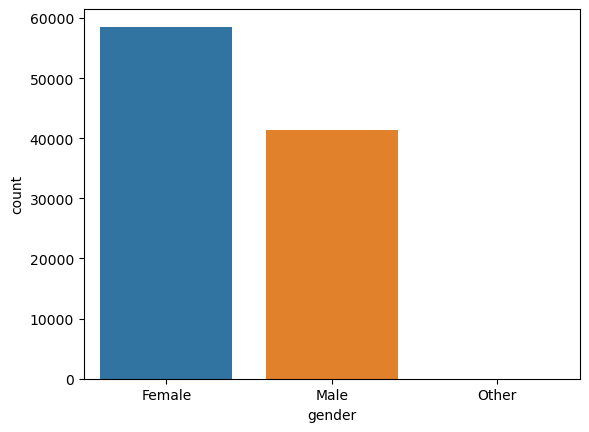

Unique values in gender: Index(['Female', 'Male', 'Other'], dtype='object')


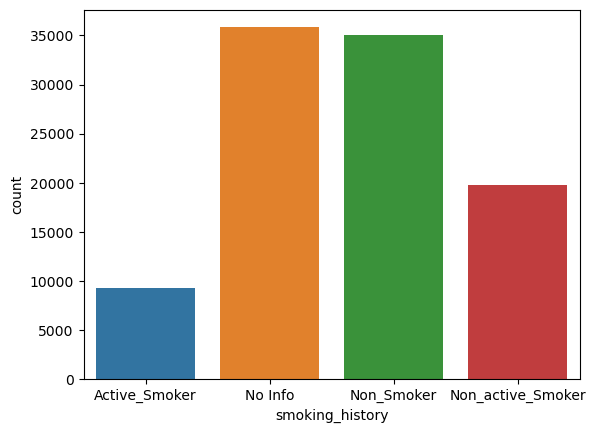

Unique values in smoking_history: Index(['Active_Smoker', 'No Info', 'Non_Smoker', 'Non_active_Smoker'], dtype='object')


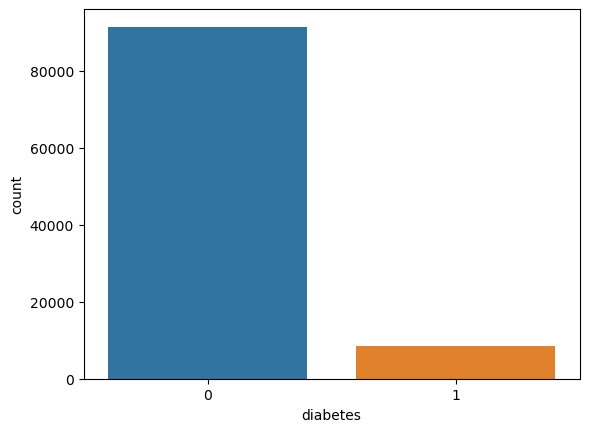

Unique values in diabetes: Index([0, 1], dtype='int64')


In [8]:
# Exploring categorical columns
for col in CatCols:
    if df[col].dtype.name == 'category':
        sns.countplot(x=col, data=df)
        plt.show()
        print(f"Unique values in {col}: {df[col].cat.categories}")
    else:
        print(f"Column {col} is not categorical.")

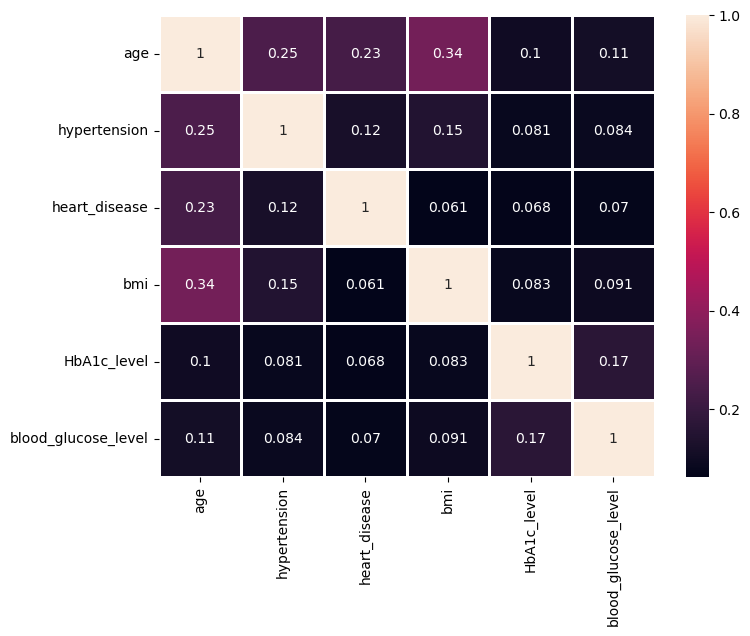

In [11]:
# Ensure that we only include numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, linewidths=2)
plt.show()

In [14]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)  # One-hot encoding

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)

# Scale the entire dataset (now that it's all numeric)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# PCA analysis
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
# Model training with XGBoost
xgbc = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=8)
xgbc.fit(X_train_pca, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# Predictions
predictions = xgbc.predict(X_test_pca)


In [18]:
# Model Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('Accuracy Score:', round(accuracy_score(y_test, predictions), 2))



[[22727   148]
 [  829  1296]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     22875
           1       0.90      0.61      0.73      2125

    accuracy                           0.96     25000
   macro avg       0.93      0.80      0.85     25000
weighted avg       0.96      0.96      0.96     25000

Accuracy Score: 0.96


In [19]:
# Comment on results
# - The XGBoost model exhibits high accuracy on the test data, but consider cross-validation and additional metrics for robust evaluation.